# NBA Team Offensive Playstyle Clustering

## IMPORTING DATA & LIBRARIES

In [1]:
# nba data
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import leaguedashplayerptshot
from nba_api.stats.endpoints import leaguedashteamstats

# packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn

# scikit
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import decomposition

In [2]:
# pull team data for regular season
team_data_reg = leaguedashteamstats.LeagueDashTeamStats(
    season='2022-23',
    season_type_all_star='Regular Season'
).get_data_frames()[0]
team_data_reg

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,41,41,0.500,3971.0,3658,7574,0.483,...,10,18,3,18,12,21,6,19,3,18
1,1610612738,Boston Celtics,82,57,25,0.695,3996.0,3460,7278,0.475,...,7,7,7,27,6,4,7,25,4,1
2,1610612751,Brooklyn Nets,82,45,37,0.549,3946.0,3399,6978,0.487,...,29,13,14,16,1,3,25,28,20,15
3,1610612766,Charlotte Hornets,82,27,55,0.329,3966.0,3385,7413,0.457,...,9,17,17,9,8,29,17,13,27,27
4,1610612741,Chicago Bulls,82,40,42,0.488,3981.0,3488,7116,0.490,...,22,20,8,7,19,18,8,27,22,13
5,1610612739,Cleveland Cavaliers,82,51,31,0.622,3976.0,3408,6984,0.488,...,25,19,6,15,14,13,9,10,25,2
6,1610612742,Dallas Mavericks,82,38,44,0.463,3986.0,3283,6909,0.475,...,30,28,2,29,28,2,23,1,16,19
7,1610612743,Denver Nuggets,82,53,29,0.646,3951.0,3574,7088,0.504,...,19,2,20,11,20,10,4,23,12,6
8,1610612765,Detroit Pistons,82,17,65,0.207,3961.0,3244,7140,0.454,...,21,27,25,20,27,27,30,3,29,29
9,1610612744,Golden State Warriors,82,44,38,0.537,3966.0,3538,7393,0.479,...,8,1,30,14,25,6,28,30,2,11


In [3]:
# pull team data for playoffs
team_data_po = leaguedashteamstats.LeagueDashTeamStats(
    season='2022-23',
    season_type_all_star='Playoffs'
).get_data_frames()[0]
team_data_po

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,6,2,4,0.333,288.0,264,578,0.457,...,11,10,5,10,10,8,3,14,10,12
1,1610612738,Boston Celtics,20,11,9,0.550,965.0,817,1710,0.478,...,3,3,15,3,1,14,14,3,3,2
2,1610612751,Brooklyn Nets,4,0,4,0.000,192.0,136,309,0.440,...,16,16,1,16,16,1,1,16,16,15
3,1610612739,Cleveland Cavaliers,5,1,4,0.200,240.0,176,392,0.449,...,15,14,7,12,14,4,4,15,15,11
4,1610612743,Denver Nuggets,20,16,4,0.800,965.0,845,1719,0.492,...,2,2,14,2,3,14,15,2,2,1
5,1610612744,Golden State Warriors,13,6,7,0.462,624.0,545,1217,0.448,...,5,5,12,5,6,11,13,5,5,6
6,1610612746,LA Clippers,5,1,4,0.200,240.0,204,443,0.460,...,13,15,3,13,12,5,6,11,13,12
7,1610612747,Los Angeles Lakers,16,8,8,0.500,773.0,657,1394,0.471,...,4,4,13,4,2,13,12,4,4,3
8,1610612763,Memphis Grizzlies,6,2,4,0.333,293.0,230,572,0.402,...,10,11,6,11,12,10,7,12,11,15
9,1610612748,Miami Heat,23,13,10,0.565,1109.0,914,1997,0.458,...,1,1,16,1,4,16,16,1,1,4


## EDA

In [4]:
# make columns lowercase
team_data_reg.columns = map(str.lower, team_data_reg.columns)

team_data_po.columns = map(str.lower, team_data_po.columns)

In [5]:
team_data_po.columns

Index(['team_id', 'team_name', 'gp', 'w', 'l', 'w_pct', 'min', 'fgm', 'fga',
       'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb',
       'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts',
       'plus_minus', 'gp_rank', 'w_rank', 'l_rank', 'w_pct_rank', 'min_rank',
       'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank',
       'fg3_pct_rank', 'ftm_rank', 'fta_rank', 'ft_pct_rank', 'oreb_rank',
       'dreb_rank', 'reb_rank', 'ast_rank', 'tov_rank', 'stl_rank', 'blk_rank',
       'blka_rank', 'pf_rank', 'pfd_rank', 'pts_rank', 'plus_minus_rank'],
      dtype='object')

In [6]:
# drop columns for both dfs that aren't related to playstyle - typically anything related to winning
team_data_reg = team_data_reg.drop(['team_id','gp','w','l','w_pct','min','plus_minus','plus_minus_rank','gp_rank','w_rank','l_rank','w_pct_rank', 'min_rank','dreb','reb','stl','blk','blka', 'pf','dreb_rank', 'reb_rank','stl_rank', 'blk_rank',
       'blka_rank', 'pf_rank'],axis=1)
team_data_po = team_data_po.drop(['team_id','gp','w','l','w_pct','min','plus_minus','plus_minus_rank','gp_rank','w_rank','l_rank','w_pct_rank', 'min_rank','dreb','reb','stl','blk','blka', 'pf','dreb_rank', 'reb_rank','stl_rank', 'blk_rank',
       'blka_rank', 'pf_rank'],axis=1)

In [7]:
team_data_reg.columns

Index(['team_name', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm',
       'fta', 'ft_pct', 'oreb', 'ast', 'tov', 'pfd', 'pts', 'fgm_rank',
       'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank',
       'ftm_rank', 'fta_rank', 'ft_pct_rank', 'oreb_rank', 'ast_rank',
       'tov_rank', 'pfd_rank', 'pts_rank'],
      dtype='object')

In [8]:
# create new dataframe with team names only then drop in other dataframe so that kmeans can be performed
teams = team_data_reg[['team_name']]
teams.head()

,team_name
0,Atlanta Hawks
1,Boston Celtics
2,Brooklyn Nets
3,Charlotte Hornets
4,Chicago Bulls


In [9]:
# drop in df team names
team_data_reg = team_data_reg.drop(['team_name'],axis=1)
team_data_po = team_data_po.drop(['team_name'],axis=1)

## REGULAR SEASON

In [10]:
# identify numeric features
numeric_features = team_data_reg.columns.tolist()

# create numeric transformer
numeric_transformer = StandardScaler()

# create column transformer
scaler = make_column_transformer((numeric_transformer,numeric_features))

# scale data
scale = scaler.fit_transform(team_data_reg)


# to df
team_reg_scaled = pd.DataFrame(scale, columns = numeric_features)
team_reg_scaled.head()

,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,...,fg3a_rank,fg3_pct_rank,ftm_rank,fta_rank,ft_pct_rank,oreb_rank,ast_rank,tov_rank,pfd_rank,pts_rank
0,2.072546,1.605468,0.630008,-0.982028,-1.010902,-0.524078,0.046085,-0.643287,1.384547,0.572230,...,1.444178,0.635438,0.061482,0.523526,-1.444178,-0.747967,0.294397,-1.436508,0.407319,-1.444178
1,0.172712,0.179812,-0.039027,2.289720,2.309800,1.086818,-0.703611,-1.300089,1.153789,-0.530150,...,-1.559712,-1.097575,0.983714,1.447396,-1.328644,0.530940,-0.983905,-0.975596,1.098993,-1.328644
2,-0.412590,-1.265109,0.964526,0.272268,-0.115961,1.151254,-0.577039,-0.959525,0.692274,-1.614749,...,-0.288836,-1.213110,0.407319,1.100945,-0.982041,1.577318,-0.286650,-0.169001,1.444829,0.519904
3,-0.546922,0.830027,-1.544356,-0.989584,-0.459134,-1.941667,-0.596511,0.021623,-1.269168,0.403317,...,0.288836,1.559712,0.522598,0.177075,1.328644,-0.399174,0.178188,0.176683,-0.284355,1.328644
4,0.441376,-0.600445,1.215414,-1.193596,-1.475195,0.055844,-0.606248,-1.146025,1.038410,-1.436946,...,1.675247,0.057767,0.637877,1.216429,-1.213110,1.461054,0.526815,-0.860368,1.329550,0.750973


### elbow method for IDing K

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

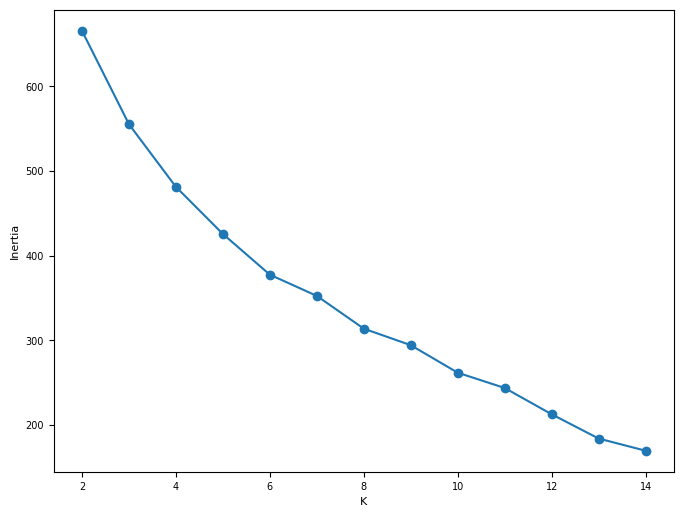

In [11]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.plot(range(2, 15), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
inertia_values = list()
for k in range(2, 15):
    inertia_values.append(KMeans(n_clusters=k).fit(team_reg_scaled).inertia_)
plot_elbow(8, 6, inertia_values)

### silhouette method

In [12]:
for i in range(2,15):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(team_reg_scaled).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
    +str(metrics.silhouette_score(team_reg_scaled,labels,metric="euclidean",sample_size=1000,random_state=200)))

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Silhouette score for k(clusters) = 2 is 0.15513926225842792
Silhouette score for k(clusters) = 3 is 0.1476330664256997
Silhouette score for k(clusters) = 4 is 0.12790911883992634
Silhouette score for k(clusters) = 5 is 0.1429006124678545


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for k(clusters) = 6 is 0.15644940699321233
Silhouette score for k(clusters) = 7 is 0.1545360510424879
Silhouette score for k(clusters) = 8 is 0.1489228961818614
Silhouette score for k(clusters) = 9 is 0.16293860230534385


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Silhouette score for k(clusters) = 10 is 0.13901723332502497
Silhouette score for k(clusters) = 11 is 0.12516309657227734
Silhouette score for k(clusters) = 12 is 0.13081337369136758
Silhouette score for k(clusters) = 13 is 0.143306011113054
Silhouette score for k(clusters) = 14 is 0.11620294684619395


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### try k=6,9

## KNN w PCA to reduce dimensionality


### k=6

In [14]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(team_reg_scaled)
pca_team_reg_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_team_reg_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=6)
kmeans_fit = kmeans_rp.fit(pca_team_reg_df)

# add predictions to dataframe
pca_team_reg_df["cluster"] = kmeans_rp.labels_
pca_team_reg_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PC1,PC2,cluster
0,1.210130,2.024668,3
1,4.675730,-1.542549,1
2,2.237887,-3.005194,2
3,-2.749772,3.415336,5
4,0.706251,-0.873720,2


In [15]:
# get variance explained by principal components
print(pca.explained_variance_ratio_.round(2)[:10])

[0.31 0.22]


In [16]:
# create final dataframe to visualize
team_reg_final = pd.concat([teams,pca_team_reg_df], axis=1)
team_reg_final.head()

,team_name,PC1,PC2,cluster
0,Atlanta Hawks,1.210130,2.024668,3
1,Boston Celtics,4.675730,-1.542549,1
2,Brooklyn Nets,2.237887,-3.005194,2
3,Charlotte Hornets,-2.749772,3.415336,5
4,Chicago Bulls,0.706251,-0.873720,2


In [23]:
team_reg_kmeans_graph = alt.Chart(team_reg_final,title= 'NBA Team Playstyles Kmeans Clustering (K=6)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (31%)'),
         alt.Y('PC2',title = 'Principal Component 2 (22%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('team_name',title='team')])

team_reg_kmeans_graph

alt.Chart(...)

### k = 9 

In [24]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(team_reg_scaled)
pca_team_reg_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_team_reg_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=9)
kmeans_fit = kmeans_rp.fit(pca_team_reg_df)

# add predictions to dataframe
pca_team_reg_df["cluster"] = kmeans_rp.labels_
pca_team_reg_df.head()

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PC1,PC2,cluster
0,1.210130,2.024668,1
1,4.675730,-1.542549,6
2,2.237887,-3.005194,6
3,-2.749772,3.415336,0
4,0.706251,-0.873720,3


In [25]:
# create final dataframe to visualize
team_reg_final = pd.concat([teams,pca_team_reg_df], axis=1)
team_reg_final.head()

,team_name,PC1,PC2,cluster
0,Atlanta Hawks,1.210130,2.024668,1
1,Boston Celtics,4.675730,-1.542549,6
2,Brooklyn Nets,2.237887,-3.005194,6
3,Charlotte Hornets,-2.749772,3.415336,0
4,Chicago Bulls,0.706251,-0.873720,3


In [26]:
team_reg_kmeans_graph = alt.Chart(team_reg_final,title= 'NBA Team Playstyles Kmeans Clustering (K=6)').mark_point(
).encode(alt.X('PC1',title ='Principal Component 1 (31%)'),
         alt.Y('PC2',title = 'Principal Component 2 (22%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('team_name',title='team')])

team_reg_kmeans_graph

alt.Chart(...)